In [25]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from sklearn import datasets, svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Working with Tensors

In [3]:
t1 = torch.rand(3, 3, device=device,  dtype=torch.float16)

print(t1.size())
print(t1.device)

t2 = torch.rand(3, 3, device=device,  dtype=torch.float16)

# Element-wise
print(t1 + t2)
print(t1 * t2)

# Matrix multiplication
print(t1 @ t2)

# Slicing
print(t1[0, 0])
print(t1[0, :])
print(t1[:, 0])

t1.view(-1, 1)

torch.Size([3, 3])
cuda:0
tensor([[0.5244, 0.8491, 1.2822],
        [1.3184, 1.1992, 0.8613],
        [1.6533, 0.6348, 1.5820]], device='cuda:0', dtype=torch.float16)
tensor([[0.0681, 0.1674, 0.3958],
        [0.3848, 0.3474, 0.0166],
        [0.6572, 0.0561, 0.6079]], device='cuda:0', dtype=torch.float16)
tensor([[1.0547, 0.4082, 1.0137],
        [0.7485, 0.4849, 0.9429],
        [1.5391, 0.5640, 1.5615]], device='cuda:0', dtype=torch.float16)
tensor(0.2881, device='cuda:0', dtype=torch.float16)
tensor([0.2881, 0.5381, 0.5176], device='cuda:0', dtype=torch.float16)
tensor([0.2881, 0.4355, 0.6646], device='cuda:0', dtype=torch.float16)


tensor([[0.2881],
        [0.5381],
        [0.5176],
        [0.4355],
        [0.7090],
        [0.0197],
        [0.6646],
        [0.5288],
        [0.9253]], device='cuda:0', dtype=torch.float16)

PyTorch Tensors + NumPy

In [4]:
a = torch.ones(5)
b = a.numpy()  # Pointer to the same memory!

c = np.ones(5)
d = torch.from_numpy(c)  # Pointer to the same memory, again!

d = d.to(device)  # Move to GPU

a, b, c, d

(tensor([1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1.], device='cuda:0', dtype=torch.float64))

### PyTorch AutoGrad

Theoretical:

* Jacobian Matrix, Chain Rule

In [5]:
x = torch.randn(3, requires_grad=True)
y = x + 2
z = y * y * 2
z = z.mean()

v = torch.tensor([0.1, 1.0, 0.001], dtype=torch.float32)
z.backward()  # dz/dx, pass v to multiply by the gradient

# Prevent gradient tracking
# x.requires_grad_(False)
# y = x.detach()
# with torch.no_grad():
#     pass

x.grad

tensor([4.0305, 1.5738, 1.7052])

In [6]:
weights = torch.ones(4, requires_grad=True)
epochs = 3

for epoch in range(epochs):
    model_output = (weights * 3).sum()
    model_output.backward()
    
    print(weights.grad)
    
    # Clean the gradient
    weights.grad.zero_()

tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])


### Backpropagation

Chain Rule:

$$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} * \frac{\partial y}{\partial x}$$

Computational Graph:

* Graph is created and updated on every operation
* Allows the calculation of local gradients
* Calculate loss:

$$\frac{\partial Loss}{\partial x} = \frac{\partial Loss}{\partial z} * \frac{\partial z}{\partial x}$$

Steps: 
1. Forward pass: Calculate loss
2. Compute local gradients
3. Backward pass: Calculate dLoss/dWeights using chain rule

In [7]:
x = torch.tensor(1.0)
y = torch.tensor(2.0)

w = torch.tensor(1.0, requires_grad=True)

# Forward pass and compute the loss
y_hat = w * x
loss = (y_hat - y) ** 2

print("Loss:\t\t", loss)

# Backward pass
loss.backward()
print("Gradient:\t", w.grad)

Loss:		 tensor(1., grad_fn=<PowBackward0>)
Gradient:	 tensor(-2.)


### Gradient Descent using Autograd

Training pipeline:
1. Design model (input, output size, forward pass)
2. Construct loss and optimizer
3. Training loop
    * Forward pass: compute prediction
    * Backward pass: gradients
    * Update weights

In [8]:
X = torch.tensor([[1], [2], [3], [4]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

X_test = torch.tensor([5], dtype=torch.float32)

n_samples, n_features = X.shape

input_size = n_features
output_size = n_features

model = nn.Linear(input_size, output_size)

# w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

# model prediction, manually
# def forward(x):
#     return w * x

# loss (MSE), manually
# def loss(y, y_predicted):
#     return ((y_predicted-y)**2).mean()

# gradient, manually
# MSE = 1/n * (w*x - y) ** 2
# dJ/dw = 1/n ex (w*x - y)
# def gradient(x, y, y_predicted):
#     return np.dot(2*x, y_predicted-y) / len(x)

class LinearRegression(nn.Module):
    
    def __init__(self, input_dim, ouput_dim):
        super(LinearRegression, self).__init__()
        self.lin = nn.Linear(input_dim, ouput_dim)
        
    def forward(self, x):
        return self.lin(x)


model = LinearRegression(input_size, output_size)

print(f"Prediction before training: f(5) = {model(X_test).item():.3f}")

learning_rate = 0.05
n_iters = 500

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(n_iters):
    # prediction = forward pass
    y_pred = model(X)
    
    # loss
    l = loss(Y, y_pred)
    
    # gradients manually
    # dw = gradient(X, Y, y_pred)
    
    # gradient = backward pass
    l.backward()
    
    # update weights
    optimizer.step()
        
    # zero gradients
    optimizer.zero_grad()
    
    if (epoch + 1) % (n_iters / 10) == 0:
        [w, b] = model.parameters()
        print(f"Epoch {epoch+1}: w = {w[0][0].item():.3f}, loss = {l:.8f}")

print(f"Prediction after training: f(5) = {model(X_test).item():.3f}")

Prediction before training: f(5) = -1.418
Epoch 50: w = 1.822, loss = 0.04695665
Epoch 100: w = 1.916, loss = 0.01039116
Epoch 150: w = 1.961, loss = 0.00229950
Epoch 200: w = 1.982, loss = 0.00050886
Epoch 250: w = 1.991, loss = 0.00011260
Epoch 300: w = 1.996, loss = 0.00002492
Epoch 350: w = 1.998, loss = 0.00000551
Epoch 400: w = 1.999, loss = 0.00000122
Epoch 450: w = 2.000, loss = 0.00000027
Epoch 500: w = 2.000, loss = 0.00000006
Prediction after training: f(5) = 10.000


### Linear Regression

Epoch: 10, loss = 4327.0513
Epoch: 20, loss = 3231.5046
Epoch: 30, loss = 2438.1963
Epoch: 40, loss = 1863.1646
Epoch: 50, loss = 1445.9622
Epoch: 60, loss = 1143.0083
Epoch: 70, loss = 922.8420
Epoch: 80, loss = 762.7228
Epoch: 90, loss = 646.1957
Epoch: 100, loss = 561.3403


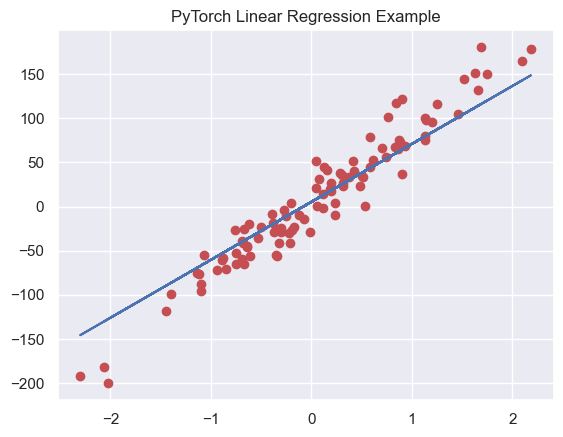

In [9]:
# Prepare Data
X_numpy, y_numpy = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=1)

X = torch.from_numpy(X_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy.astype(np.float32))
y = y.view(y.shape[0], 1)

n_samples, n_features = X.shape

# Model
input_size = n_features
output_size = 1

model = nn.Linear(input_size, output_size)

# Loss, Optimizer
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training Loop
n_iters = 100

for epoch in range(n_iters):
    # Forward pass, loss
    y_pred = model(X)
    loss = criterion(y_pred, y)
    
    # Backward pass
    loss.backward()
    
    # Update
    optimizer.step()
    optimizer.zero_grad()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}, loss = {loss.item():.4f}")
        
# Plot
predicted = model(X).detach().numpy()

sns.set()
plt.plot(X_numpy, y_numpy, "ro")
plt.plot(X_numpy, predicted, "b")
plt.title("PyTorch Linear Regression Example")
plt.show()

### Logistic Regression

In [10]:
# Prepare data
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target

n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

# Model
class LogisticRegression(nn.Module):
    
    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)
    
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
model = LogisticRegression(n_features)

# Loss, Optimizer
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
n_iters = 100

for epoch in range(n_iters):
    # Forward pass, loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    # Backward pass
    loss.backward()
    
    # Updates
    optimizer.step()
    optimizer.zero_grad()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}, loss = {loss.item():.4f}")
        
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_classes = y_pred.round()
    acc = y_pred_classes.eq(y_test).sum() / float(y_test.shape[0])
    print(f"Accuracy = {acc:.4f}")

Epoch: 10, loss = 0.6563
Epoch: 20, loss = 0.5401
Epoch: 30, loss = 0.4665
Epoch: 40, loss = 0.4152
Epoch: 50, loss = 0.3772
Epoch: 60, loss = 0.3475
Epoch: 70, loss = 0.3235
Epoch: 80, loss = 0.3037
Epoch: 90, loss = 0.2869
Epoch: 100, loss = 0.2725
Accuracy = 0.9035


### Datasets, Data Loader

Terminology:

* epoch = 1 forward and backward pass of all training samples
* batch_size = number of training samples in one forward & backward pass
* number of iterations = number of passes, each pass using [batch_size] number of samples

e.g. 100 samples, batch_size=20 -> 100/20 = 5 iterations for 1 epoch

In [11]:
class WineDataset(Dataset):
    
    def __init__(self, transform=None):
        xy = np.loadtxt("data/wine/wine.csv", delimiter=',', dtype=np.float32, skiprows=1)
        
        self.x = xy[:, 1:]
        self.y = xy[:, [0]]
        
        self.n_samples = xy.shape[0]
        
        self.transform = transform
    
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
    
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
    def __len__(self):
        return self.n_samples
    

class ToTensor:
    
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)
    
    
class MulTransform:
    
    def __init__(self, factor):
        self.factor = factor
        
    def __call__(self, sample):
        inputs, target = sample
        inputs *= self.factor
        return inputs, target

    
dataset = WineDataset()
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True)

n_epochs = 2
total_samples = len(dataset)
n_iters = math.ceil(total_samples/4)

for epoch in range(n_epochs):
    for i, (inputs, labels) in enumerate(dataloader):
        # forward backward update
        
        if (i+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iters}, inputs {inputs.shape}")

Epoch 1/2, step 5/45, inputs torch.Size([4, 13])
Epoch 1/2, step 10/45, inputs torch.Size([4, 13])
Epoch 1/2, step 15/45, inputs torch.Size([4, 13])
Epoch 1/2, step 20/45, inputs torch.Size([4, 13])
Epoch 1/2, step 25/45, inputs torch.Size([4, 13])
Epoch 1/2, step 30/45, inputs torch.Size([4, 13])
Epoch 1/2, step 35/45, inputs torch.Size([4, 13])
Epoch 1/2, step 40/45, inputs torch.Size([4, 13])
Epoch 1/2, step 45/45, inputs torch.Size([2, 13])
Epoch 2/2, step 5/45, inputs torch.Size([4, 13])
Epoch 2/2, step 10/45, inputs torch.Size([4, 13])
Epoch 2/2, step 15/45, inputs torch.Size([4, 13])
Epoch 2/2, step 20/45, inputs torch.Size([4, 13])
Epoch 2/2, step 25/45, inputs torch.Size([4, 13])
Epoch 2/2, step 30/45, inputs torch.Size([4, 13])
Epoch 2/2, step 35/45, inputs torch.Size([4, 13])
Epoch 2/2, step 40/45, inputs torch.Size([4, 13])
Epoch 2/2, step 45/45, inputs torch.Size([2, 13])


### Dataset Transforms

In [12]:
# dataset = torchvision.datasets.MNIST(root="./data", transform=torchvision.transforms.ToTensor())
dataset = WineDataset(transform=None)
first_data = dataset[0]
features, labels = first_data
print(features)
print(type(features), type(labels))

composed = torchvision.transforms.Compose([ToTensor(), MulTransform(4)])
dataset = WineDataset(transform=composed)
first_data = dataset[0]
features, labels = first_data
print(features)
print(type(features), type(labels))

[1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
tensor([5.6920e+01, 6.8400e+00, 9.7200e+00, 6.2400e+01, 5.0800e+02, 1.1200e+01,
        1.2240e+01, 1.1200e+00, 9.1600e+00, 2.2560e+01, 4.1600e+00, 1.5680e+01,
        4.2600e+03])
<class 'torch.Tensor'> <class 'torch.Tensor'>


### Softmax & Cross-Entropy

**Softmax**:

$$
S(y_i) = \frac{e^{y_i}}{\sum e^{y_i}} 
$$

**Cross-Entropy**:

$$
D(\hat Y, Y) = - \frac{1}{n} \sum Y_i * log(\hat Y_i)
$$

* $CE$ is low if prediction is good
* $Y$ is one-hot encoded
* $\hat Y$ are probabilities

In [13]:
# Manually
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def cross_entropy(actual, predicted):
    loss = -np.sum(actual * np.log(predicted))
    return loss  # / float(predicted.shape[0])

x = np.array([2.0, 1.0, 0.1])
print("Numpy softmax:", softmax(x))

x = torch.from_numpy(x)
print("Torch softmax:", torch.softmax(x, dim=0))

# Y must be one hot encoded
# if class 0: [1 0 0]
# if class 1: [0 1 0]
# if class 2: [0 0 1]
Y = np.array([1, 0, 0])

# Y_pred has probabilities
Y_pred_good = np.array([0.7, 0.2, 0.1])
Y_pred_bad = np.array([0.1, 0.3, 0.6])

l1 = cross_entropy(Y, Y_pred_good)
l2 = cross_entropy(Y, Y_pred_bad)

print(f"Loss1 numpy: {l1:.4f}")
print(f"Loss2 numpy: {l2:.4f}")

loss = nn.CrossEntropyLoss()

Y = torch.tensor([2, 0, 1])
# nsamples * nclasses = 3*3
Y_pred_good = torch.tensor([[0.1, 1.0, 2.1], [2.0, 1.0, 0.1], [0.1, 3.0, 0.1]])
Y_pred_bad = torch.tensor([[2.1, 1.0, 0.1], [0.1, 1.0, 2.1], [0.1, 3.0, 0.1]])
 
l1 = loss(Y_pred_good, Y)
l2 = loss(Y_pred_bad, Y)

print(f"Loss1 torch: {l1.item():.4f}")
print(f"Loss2 torch: {l2.item():.4f}")

_, prediction1 = torch.max(Y_pred_good, 1)
_, prediction2 = torch.max(Y_pred_bad, 1)

prediction1, prediction2

Numpy softmax: [0.65900114 0.24243297 0.09856589]
Torch softmax: tensor([0.6590, 0.2424, 0.0986], dtype=torch.float64)
Loss1 numpy: 0.3567
Loss2 numpy: 2.3026
Loss1 torch: 0.3018
Loss2 torch: 1.6242


(tensor([2, 0, 1]), tensor([0, 2, 1]))

### Activation Functions

* used to perform more complex tasks
* else, it would be just a big linear regression model

Examples:

* Step Function $f(x) = \begin{align}\begin{cases}1 & x \ge 0 \\ 0 & x < 0\end{cases}\end{align}$
* Sigmoid Function $f(x) = \frac{1}{1+e^{-x}}$ -> Last layer in binary classification
* TanH Function $f(x) = \frac{2}{1+e^{-2x}} - 1$ -> hidden layer
* ReLU $f(x) = max(0, x)$ -> hidden layers (default)
* Leaky ReLU $f(x) = \begin{align}\begin{cases}x & x \ge 0 \\ a*x & x < 0\end{cases}\end{align}$ -> solves vanishing gradient problem
* Softmax $S(y_i) = \frac{e^{y_i}}{\sum e^{y_i}}$ -> Last layer in multi class classification

In [14]:
# Option 1 (create nn modules)
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out
    

# Option 2 (use activation functions directly in forward pass)
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out = torch.relu(self.linear1(x))
        out = torch.sigmoid(self.linear2(out))
        return out

### Feed-Forward Network

Using device 'cuda'
Epoch 1/2, step 100/600, loss = 0.1590
Epoch 1/2, step 200/600, loss = 0.0995
Epoch 1/2, step 300/600, loss = 0.0957
Epoch 1/2, step 400/600, loss = 0.2113
Epoch 1/2, step 500/600, loss = 0.0911
Epoch 1/2, step 600/600, loss = 0.1761
Epoch 2/2, step 100/600, loss = 0.0852
Epoch 2/2, step 200/600, loss = 0.2464
Epoch 2/2, step 300/600, loss = 0.0989
Epoch 2/2, step 400/600, loss = 0.0645
Epoch 2/2, step 500/600, loss = 0.0802
Epoch 2/2, step 600/600, loss = 0.1958
Accuracy = 96.43 %


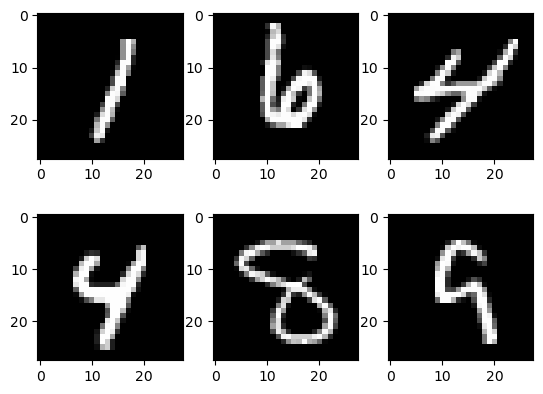

In [3]:
writer = SummaryWriter("runs/MNIST/")

input_size = 784  # 28x28 images
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.01

training_dataset = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap="gray")

# plt.show()

img_grid = torchvision.utils.make_grid(samples)
writer.add_image("mnist_images", img_grid)
writer.close()

class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

writer.add_graph(model, samples.reshape(-1, 28*28).to(device))
writer.close()

n_total_steps = len(train_loader)
running_loss = 0.0
running_correct = 0

print(f"Using device '{device}'")

# Training
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}")
            writer.add_scalar("training_loss", running_loss/100, epoch*n_total_steps + i)
            writer.add_scalar("accuracy", running_correct/100, epoch*n_total_steps + i)
            writer.close()
            running_loss = 0.0
            running_correct = 0

labels_list = list()
preds_list = list()

# Test          
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # value, index
        _, predictions = torch.max(outputs, 1)
        
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
        class_predictions = [F.softmax(output, dim=0) for output in outputs]
        
        preds_list.append(class_predictions)
        labels_list.append(predictions)
    
    preds = torch.cat([torch.stack(batch) for batch in preds_list])
    labels = torch.cat(labels_list)
    
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy = {acc} %")
    
    classes = range(10)
    
    for i in classes:
        labels_i = labels == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()

### Convolutional Neural Networks (CNN)

Image classification using CIFAR-10

In [3]:
# Hyper parameters
num_epochs = 10
batch_size = 4
learning_rate = 0.001

# Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

# Network
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)  # 16*5*5 is the input size resulting from last pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
    
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

print(f"Using device '{device}'")
    
# Training
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}")

print("Finished Training")
        
# Test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for _ in range(10)]
    n_class_samples = [0 for _ in range(10)]
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            
            if label == pred:
                n_class_correct[label] += 1
            
            n_class_samples[label] += 1
            
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy (Network) = {acc} %")
    
    for i in range(10):
        acc = 100 * n_class_correct[i] / n_class_samples[i]
        print(f"Accuracy (Class {classes[i]}) = {acc} %")

Files already downloaded and verified
Files already downloaded and verified
Using device 'cuda'
Epoch 1/10, step 2000/12500, loss = 2.3104
Epoch 1/10, step 4000/12500, loss = 2.3183
Epoch 1/10, step 6000/12500, loss = 2.2891
Epoch 1/10, step 8000/12500, loss = 2.3010
Epoch 1/10, step 10000/12500, loss = 2.2188
Epoch 1/10, step 12000/12500, loss = 2.0549
Epoch 2/10, step 2000/12500, loss = 2.0732
Epoch 2/10, step 4000/12500, loss = 1.8487
Epoch 2/10, step 6000/12500, loss = 1.1629
Epoch 2/10, step 8000/12500, loss = 1.9929
Epoch 2/10, step 10000/12500, loss = 1.8918
Epoch 2/10, step 12000/12500, loss = 1.3598
Epoch 3/10, step 2000/12500, loss = 2.4098
Epoch 3/10, step 4000/12500, loss = 2.0620
Epoch 3/10, step 6000/12500, loss = 1.7082
Epoch 3/10, step 8000/12500, loss = 2.0092
Epoch 3/10, step 10000/12500, loss = 1.3633
Epoch 3/10, step 12000/12500, loss = 1.8551
Epoch 4/10, step 2000/12500, loss = 1.6485
Epoch 4/10, step 4000/12500, loss = 1.4228
Epoch 4/10, step 6000/12500, loss = 0.

### Transfer Learning

* Use pretrained model
* Alter (typically) only the last FC layer and train on new data (fine-tuning)

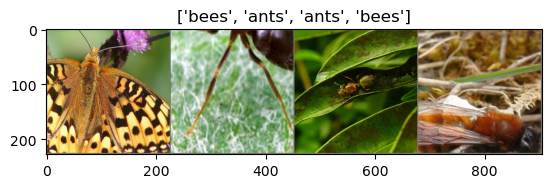

*** Fine-Tuning ***
Epoch 0/24
----------
train Loss: 0.6110 Acc: 0.7049
val Loss: 0.4831 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.6384 Acc: 0.7541
val Loss: 0.3140 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.5486 Acc: 0.7705
val Loss: 0.6468 Acc: 0.7843

Epoch 3/24
----------
train Loss: 0.4367 Acc: 0.8320
val Loss: 0.2630 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4556 Acc: 0.8320
val Loss: 0.4818 Acc: 0.8301

Epoch 5/24
----------
train Loss: 0.5568 Acc: 0.8074
val Loss: 0.3668 Acc: 0.8366

Epoch 6/24
----------
train Loss: 0.5723 Acc: 0.8074
val Loss: 0.6322 Acc: 0.8039

Epoch 7/24
----------
train Loss: 0.4436 Acc: 0.8402
val Loss: 0.3005 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.4364 Acc: 0.8197
val Loss: 0.3075 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.2870 Acc: 0.8893
val Loss: 0.2437 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.4637 Acc: 0.8320
val Loss: 0.2295 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2984 Acc: 0.8770
val Loss: 0.

In [12]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

data_dir = "data/hymenoptera_data"
sets = ["train", "val"]

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in sets
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in sets
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in sets
}

class_names = image_datasets["train"].classes

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n\n'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 
###    Option 1: Fine-tuning 
###
print("*** Fine-Tuning ***")
model = models.resnet18(weights=True)
num_features = model.fc.in_features

model.fc = nn.Linear(num_features, len(sets))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # every 7 epochs lr is multiplied by gamma

model = train_model(model, criterion, optimizer, scheduler)

###
###     Option 2: Fixed Feature Extraction
###
print("*** Fixed Feature Extractor ***")
model = models.resnet18(weights=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features

model.fc = nn.Linear(num_features, len(sets))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # every 7 epochs lr is multiplied by gamma

model = train_model(model, criterion, optimizer, scheduler)

### Save & Load Models

* torch.save(arg, PATH)
* torch.load(PATH)
* model.load_state_dict(arg)

In [13]:
class Model(nn.Module):
    
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

FILE = "model.pth"
PATH = "models"

### Option 1: Lazy
model = Model(n_input_features=6)

# Save
torch.save(model, os.path.join(PATH, FILE))
print("\n[+] Model Saved\n")

# Load
model = torch.load(os.path.join(PATH, FILE))
model.eval()

for param in model.parameters():
    print(param)
    
### Option 2: Preferred
model = Model(n_input_features=6)

# Save
torch.save(model.state_dict(), os.path.join(PATH, FILE))
print("\n[+] Model Saved\n")


# Load
loaded_model = Model(n_input_features=6)
loaded_model.load_state_dict(torch.load(os.path.join(PATH, FILE)))  # If save device differs from load device, use map_location=device
loaded_model.eval()

for param in loaded_model.parameters():
    print(param)
    
### Save checkpoint during training
optimizer = optim.SGD(model.parameters(), lr=0.01)

checkpoint = {
    "epoch": 90,
    "model_state": model.state_dict(),
    "optim_state": optimizer.state_dict()
}
 
 # Save
torch.save(checkpoint, os.path.join(PATH, "checkpoint.pth"))
print("\n[+] Checkpoint Saved\n")

# Load
loaded_checkpoint = torch.load(os.path.join(PATH, "checkpoint.pth"))

epoch = loaded_checkpoint["epoch"]

model = Model(n_input_features=6)
optimizer = optim.SGD(model.parameters(), lr=0)

model.load_state_dict(loaded_checkpoint["model_state"])
optimizer.load_state_dict(loaded_checkpoint["optim_state"])

print(optimizer.state_dict())


[+] Model Saved

Parameter containing:
tensor([[ 0.0382, -0.1344,  0.0795, -0.0846,  0.1483,  0.2171]],
       requires_grad=True)
Parameter containing:
tensor([0.2766], requires_grad=True)

[+] Model Saved

Parameter containing:
tensor([[ 0.1605,  0.2274,  0.2120,  0.3103, -0.2211, -0.3349]],
       requires_grad=True)
Parameter containing:
tensor([0.3066], requires_grad=True)

[+] Checkpoint Saved

{'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1]}]}
